In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import re

%matplotlib inline

# Fall Quarter 2017

##  Reading in Data

Starting with general data - day-to-day stuff.

In [2]:
data_path = "./data/"
general = pd.read_csv(data_path + "general.csv", skiprows=1,
                      names=["Event", "Start_time", "End_time"])

In [3]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 3 columns):
Event         1302 non-null object
Start_time    1302 non-null object
End_time      1302 non-null object
dtypes: object(3)
memory usage: 30.6+ KB


In [4]:
def convert_columns(df):
    """
    Return df with columns converted to proper datatypes (Event to string, times to datetime).
    Params:
        df: dataframe with columns 'Event', 'Start_time', and 'End_time'.
    """
    df['Event'] = df['Event'].astype(str)
    df['Start_time'] = pd.to_datetime(df['Start_time'])
    df['End_time'] = pd.to_datetime(df['End_time'])
    return df

In [5]:
general = convert_columns(general)

## Filter data by date

In [6]:
general['Start_time'].min(), general['End_time'].max()

(Timestamp('2009-06-08 23:00:00'), Timestamp('2018-09-19 16:45:00'))

Our data ranges from June 2009 to September 2018 (future events). I'm interested in Fall Quarter 2017, which started on September 25, 2017 and ended on December 15, 2017. I'm gonna go ahead and grab that data.

In [7]:
def filter_by_date(pd, date_start, date_end):
    """
    Return dataframe with rows where 'Start_time' is between date_start and date_end.
    Params:
        pd: dataframe with 'Start_time' column
        date_start: string with start date in MM/DD/YYYY format
        date_end: string with end date in MM/DD/YYYY format
    """
    start = dt.datetime.strptime(date_start, "%m/%d/%Y")
    end = dt.datetime.strptime(date_end, "%m/%d/%Y")
    return pd[(pd['Start_time'] > start) & (pd['End_time'] < end)]

In [8]:
# start and end dates for UCLA Fall 2017 quarter
fall_2017_start = "09/25/2017"
fall_2017_end = "12/16/2017"

general_f17 = filter_by_date(general, fall_2017_start, fall_2017_end)

In [9]:
general_f17.shape

(210, 3)

Look's like we've got 210 events from Fall Quarter.

I'm interested in how long events are - let's create a column for that.

In [10]:
def total_time(x):
    """
    Return total length, in hours, of an event.
    Params:
        x: dataframe row with 'Start_time' and 'End_time' columns
    """
    return (x['End_time'] - x['Start_time']).total_seconds() / 3600

In [11]:
general_f17.is_copy = False # avoid SettingWithCopyWarning

general_f17['total_time'] = general_f17.apply(lambda x: total_time(x), axis=1)

# Study Time Analysis

Gonna create some columns to indicate whether an event is about studying math, stats, or film.

In [12]:
def is_studying(event, subject):
    """
    Return True if event is about studying the subject, False otherwise.
    Params:
        event: string with event summary
        subject: string
    """
    regex_str = r"study.*{}".format(subject)
    if re.search(regex_str, event, re.IGNORECASE):
        return True
    return False

In [13]:
general_f17.is_copy = False # avoid SettingWithCopyWarning

study_math = general_f17.apply(lambda x: is_studying(x['Event'], "Math"), axis=1)
general_f17['Studying_Math'] = study_math

study_stats = general_f17.apply(lambda x: is_studying(x['Event'], "Stats"), axis=1)
general_f17['Studying_Stats'] = study_stats

study_film = general_f17.apply(lambda x: is_studying(x['Event'], "Film"), axis=1)
general_f17['Studying_Film'] = study_film

## Big picture view: how much time did I spend studying each subject?

In [14]:
math_hours = general_f17.loc[general_f17['Studying_Math'], 'total_time'].sum()
stats_hours = general_f17.loc[general_f17['Studying_Stats'], 'total_time'].sum()
film_hours = general_f17.loc[general_f17['Studying_Film'], 'total_time'].sum()

print("Total time spent studying MATH 131A: {}".format(math_hours))
print("Total time spent studying STATS 101A: {}".format(stats_hours))
print("Total time spent studying FILM TV 6A: {}".format(film_hours))

subjects = ["MATH 131A", "STATS 101A", "FILM TV 6A"]
total_times = [math_hours, stats_hours, film_hours]

Total time spent studying MATH 131A: 67.5
Total time spent studying STATS 101A: 77.5
Total time spent studying FILM TV 6A: 27.0


In [15]:
# set matplotlib parameters
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.style.use('seaborn-darkgrid')

# because matplotlib's default colors drive me insane
# inspiration from https://www.canva.com/learn/100-color-combinations/
# stored as numpy arrays for easy subsetting later
tropical_colors = np.array(["#4897D8", "#FFDB5C", "#FA6E59", "#F8A055"]) # 33. Fun & Tropical

tropical_colors_2 = tropical_colors[[0,2,3]] # FILM TV 6A, MATH 131A, STATS 101A

In [16]:
def create_plot(figsize=(15,6), title="", xlabel="", ylabel=""):
    """
    Create matplotlib plot with provided parameters. Returns fig, ax.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

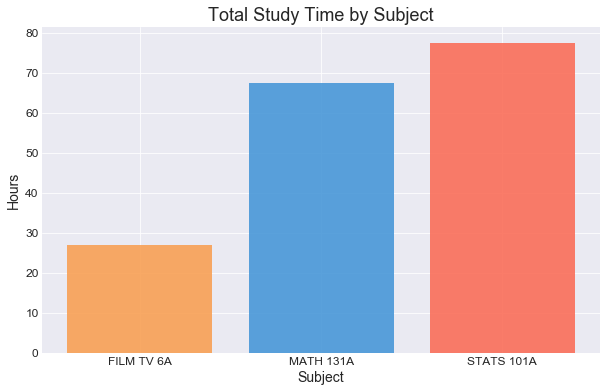

In [17]:
fig, ax = create_plot(figsize=(10, 6), title="Total Study Time by Subject", 
                      xlabel="Subject", ylabel="Hours")

g = ax.bar(subjects, total_times, color=tropical_colors_2, alpha=0.9)

plt.show()

In [18]:
# change index to day of event
general_f17 = general_f17.set_index(['Start_time'])
general_f17.index = general_f17.index.date

In [19]:
general_f17.tail()

,Event,End_time,total_time,Studying_Math,Studying_Stats,Studying_Film
2017-12-15,Study - Stats,2017-12-15 03:00:00,0.50,False,True,False
2017-12-15,Study - Math,2017-12-15 04:00:00,0.75,True,False,False
2017-12-15,Study - Math,2017-12-15 15:00:00,0.50,True,False,False
2017-12-15,Study - Math,2017-12-15 18:45:00,2.75,True,False,False
2017-12-15,Study - Math,2017-12-15 21:15:00,1.25,True,False,False


## Studying Trends

In [20]:
math_data = general_f17.loc[general_f17['Studying_Math'], :]
stats_data = general_f17.loc[general_f17['Studying_Stats'], :]
film_data = general_f17.loc[general_f17['Studying_Film'], :]
all_studying_data = general_f17.loc[(general_f17['Studying_Film'] | general_f17['Studying_Math'] \
                                    | general_f17['Studying_Stats']), :]

math_by_day = math_data.groupby(math_data.index).sum()
stats_by_day = stats_data.groupby(stats_data.index).sum()
film_by_day = film_data.groupby(film_data.index).sum()
all_studying_data = all_studying_data.groupby(all_studying_data.index).sum()

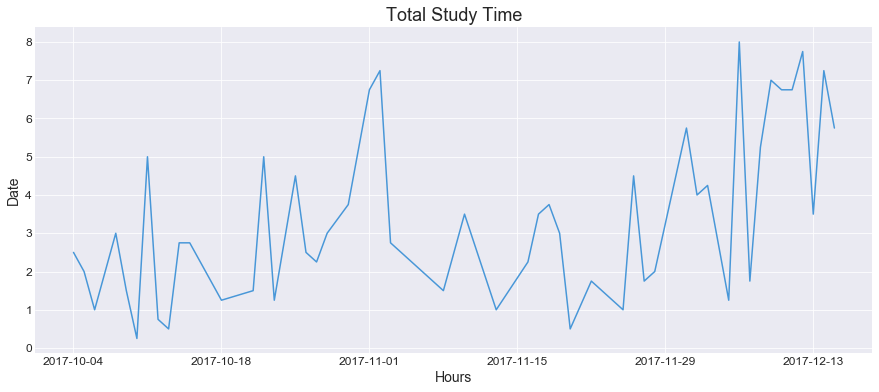

In [21]:
fig, ax = create_plot(title="Total Study Time", ylabel="Date", xlabel="Hours")

ax.plot(all_studying_data['total_time'], color=tropical_colors_2[0]);

plt.show()

### Breaking it down by subject

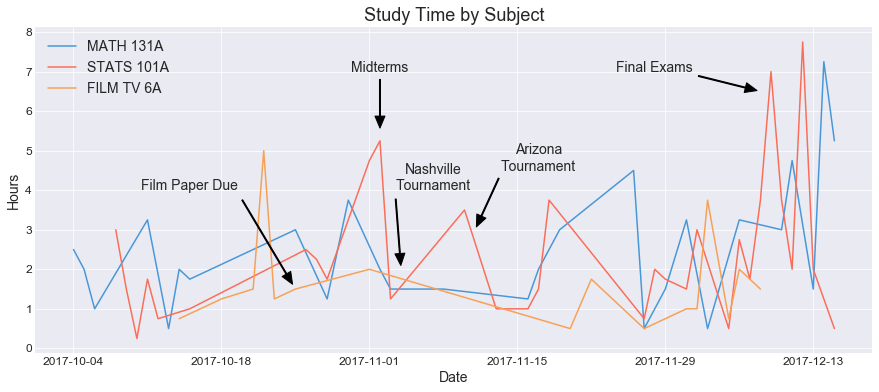

In [22]:
fig, ax = create_plot(title="Study Time by Subject", xlabel="Date", ylabel="Hours")

for i, ts in enumerate([math_by_day, stats_by_day, film_by_day]):
    ax.plot(ts['total_time'], color=tropical_colors_2[i])
    
ax.legend(['MATH 131A', 'STATS 101A', 'FILM TV 6A'])

arrowprops = dict(facecolor='black', shrink=0.05, width=1, headwidth=10)
text = {
    1: 'Midterms',
    2: 'Final Exams',
    3: 'Film Paper Due',
    4: 'Nashville\nTournament',
    5: 'Arizona\nTournament'
}
text_coordinates = {
    1: (dt.datetime(2017, 11, 2), 7),
    2: (dt.datetime(2017, 11, 28), 7),
    3: (dt.datetime(2017, 10, 15), 4),
    4: (dt.datetime(2017, 11, 7), 4),
    5: (dt.datetime(2017, 11, 17), 4.5)
}
arrow_coordinates = {
    1: (dt.datetime(2017, 11, 2), 5.5), 
    2: (dt.datetime(2017, 12, 8), 6.5),
    3: (dt.datetime(2017, 10, 25), 1.5),
    4: (dt.datetime(2017, 11, 4), 2),
    5: (dt.datetime(2017, 11, 11), 3)
}

for i in text:
    ax.annotate(text[i], size=14, horizontalalignment='center',xytext=text_coordinates[i],
                xy=arrow_coordinates[i], arrowprops=arrowprops)

plt.show()

Some observations: 
- Time spent on my FILM class was pretty spikey - I'd usually spend a ton of time before papers & exams, then neglect it for a bit.
- There's a big 'ol valley in studying in the first two weeks of November, when I spent a ton of time preparing for / traveling for mock trial tournaments

### Week-by-Week Analysis

Life in the quarter system tends to happen in weeks - 10 weeks in a quarter and finals week (week 11). Bet I can find some weekly trends, so I'm gonna go ahead and group by data by week.

In [23]:
def group_by_week(df, quarter_start, function="size"):
    """
    Return dataframe with total time grouped by week, using the function provided.
    By default, the function is 'size' to compute the number of events that week.
    Params:
        df: dataframe with date index and 'total time' column
        quarter start: string containing quarter start date in "%m/%d/%Y" format
    """
    week_1 = dt.datetime.strptime(quarter_start, "%m/%d/%Y").isocalendar()[1] # calendar week of wk 0
    if function == "sum":
        by_week = df.groupby(lambda x: x.isocalendar()[1] - week_1, as_index=True).sum()
    elif function == "mean":
        by_week = df.groupby(lambda x: x.isocalendar()[1] - week_1, as_index=True).mean()
    elif function == "size":
        by_week = df.groupby(lambda x: x.isocalendar()[1] - week_1, as_index=True).size()
    return by_week

In [24]:
math_by_week = group_by_week(math_data, fall_2017_start, "sum")
stats_by_week = group_by_week(stats_data, fall_2017_start, "sum")
film_by_week = group_by_week(film_data, fall_2017_start, "sum")
all_studying_by_week = group_by_week(all_studying_data, fall_2017_start, "sum")

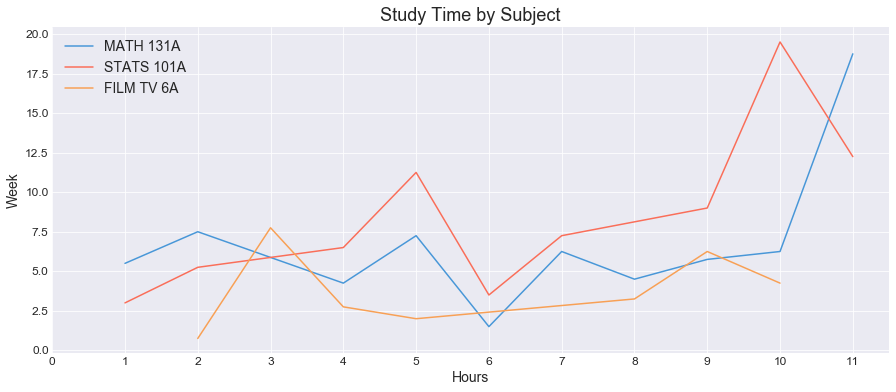

In [25]:
fig, ax = create_plot(title="Study Time by Subject", ylabel="Week", xlabel="Hours")

for i, ts in enumerate([math_by_week, stats_by_week, film_by_week]):
    ax.plot(ts['total_time'], color=tropical_colors_2[i]);

ax.legend(['MATH 131A', 'STATS 101A', 'FILM TV 6A'])
ax.set_xticks(range(12))

plt.show()

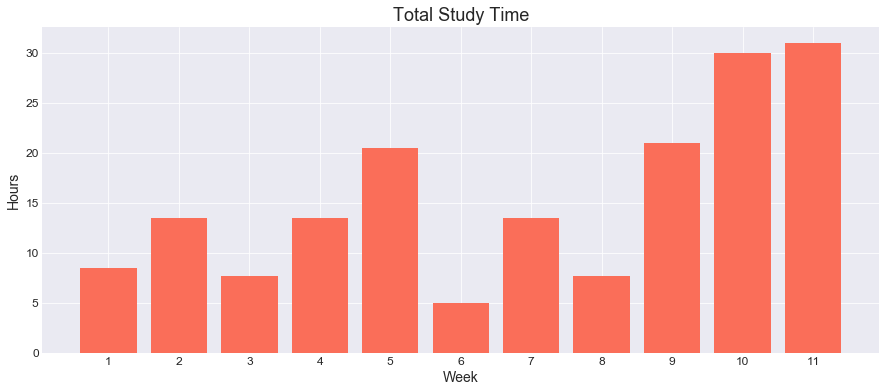

In [26]:
fig, ax = create_plot(title="Total Study Time", ylabel="Hours", xlabel="Week")

ax.bar(x=all_studying_by_week.index, height=all_studying_by_week['total_time'], color=tropical_colors_2[1]);
ax.set_xticks(all_studying_by_week.index)

plt.show()

Let's break it down by subject.

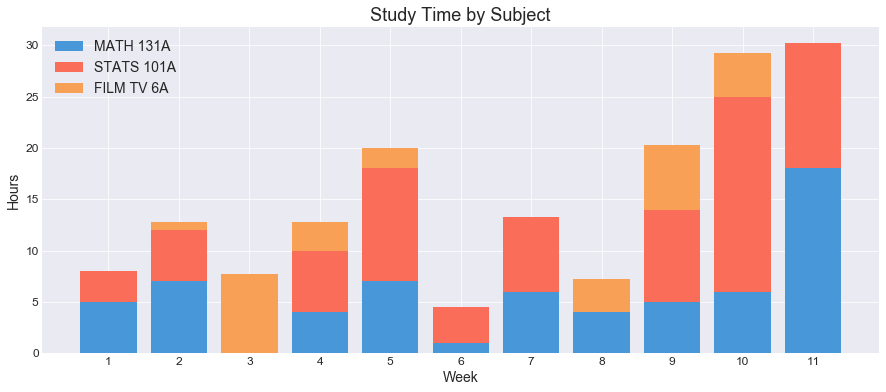

In [27]:
fig, ax = create_plot(title="Study Time by Subject", xlabel="Week", ylabel="Hours")

floor = pd.Series(0, index=range(12)) # where the next bar chart should start
    
for i, subject in enumerate([math_by_week, stats_by_week, film_by_week]):
    ax.bar(x=subject.index, height=subject['total_time'], linewidth=0, 
           bottom=floor[subject.index], color=tropical_colors_2[i]);
    for i in subject.index: 
        floor[i] += subject.loc[i]['total_time'] # gotta do it this way to avoid NaNs

ax.legend(['MATH 131A', 'STATS 101A', 'FILM TV 6A'])
ax.set_xticks(all_studying_by_week.index)

plt.show()

- Looks like the only studying I did in Week 3 was for my film class. I had a paper due that week.
- There's a peak in the middle of the quarter of Week 5 - that week I had midterms in all three classes.
- I did the least studying overall in Week 6, which makes sense. I had mock trial tournaments on the weekends going into and coming out of that week.

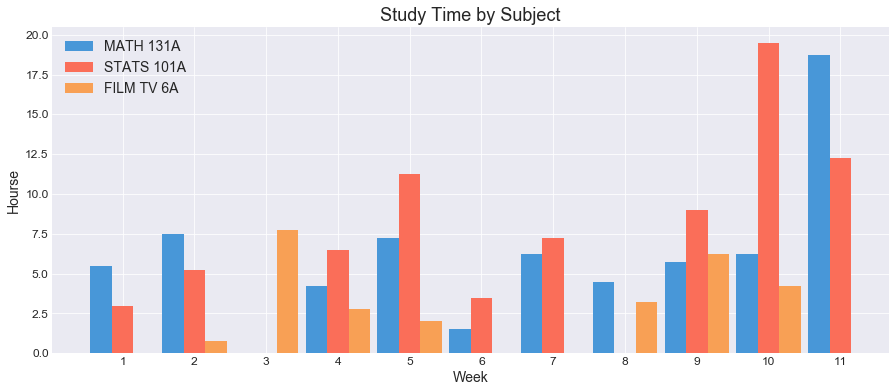

In [28]:
fig, ax = create_plot(title="Study Time by Subject", xlabel="Week", ylabel="Hourse")

for i, subject in enumerate([math_by_week, stats_by_week, film_by_week]):
    ax.bar(x=subject.index-0.3 + i*0.3, height=subject['total_time'], width=0.3, color=tropical_colors_2[i])

ax.legend(['MATH 131A', 'STATS 101A', 'FILM TV 6A'])
ax.set_xticks(all_studying_by_week.index)

plt.show()

### Weekday Analysis

I bet there are some trends in my studying patterns over the weekday. 

In [29]:
def group_by_weekday(df, function="size"):
    """
    Return dataframe with data grouped by weekday using function.
    Params:
        df: Series with dates as index.
    """
    if function == "mean":
        result = df.groupby(lambda x: calendar.day_name[x.weekday()], as_index=True).mean()
    elif function == "size":
        result = df.groupby(lambda x: calendar.day_name[x.weekday()], as_index=True).size()
    return result

In [30]:
# reindex by weekday name to get correct order of Monday - Sunday
studying_by_weekday = group_by_weekday(all_studying_data).reindex(calendar.day_name)

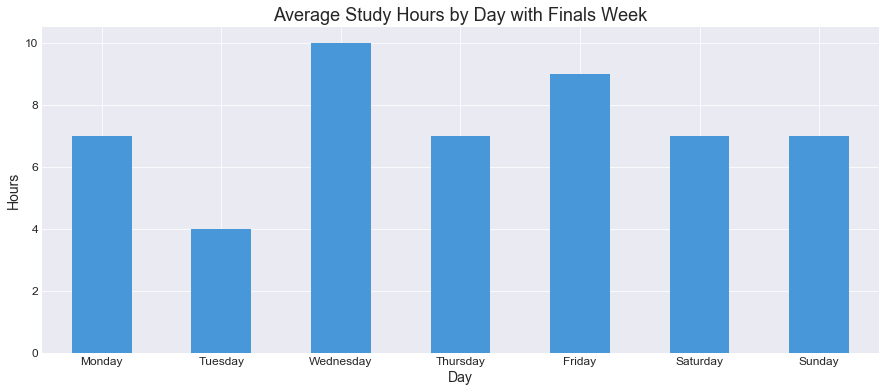

In [31]:
fig, ax = create_plot(title="Average Study Hours by Day with Finals Week", xlabel="Day",
                      ylabel="Hours")

# trying to plot using ax.Bar() was more pain than it was worth trying to order the days
studying_by_weekday.plot(kind='bar', color=tropical_colors_2[0], rot=0)

plt.show()

Hmmm, there are some differences in my day-to-day here, but they're not too large. I'm gonna try excluding finals week and looking at only the data from Week 0-10. Finals week is a bit of an "outlier" in terms of studying since I don't have any class and basically become a hermit who studies ajazillion hours each day.

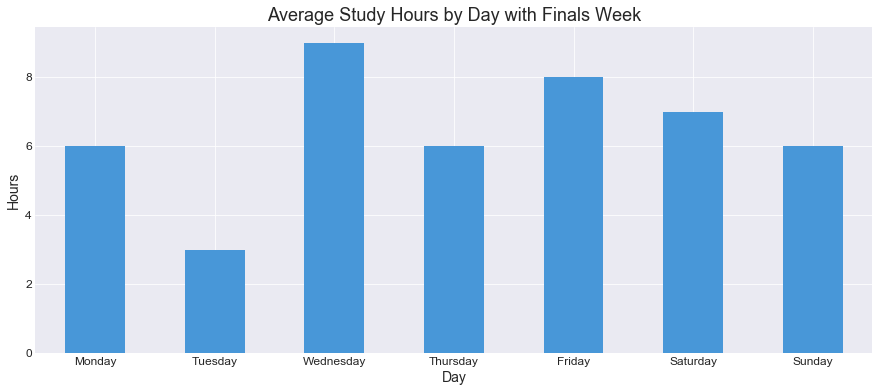

In [32]:
no_finals = group_by_weekday(all_studying_data[:-6]).reindex(calendar.day_name)

fig, ax = create_plot(title="Average Study Hours by Day with Finals Week", xlabel="Day",
                      ylabel="Hours")

no_finals.plot(kind='bar', color=tropical_colors_2[0], rot=0)

plt.show()

This makes more sense!
- Got the least amount of studying done on Mondays, Tuesdays, & Thursdays - these are the days I worked. I'm actually pretty surprised I studied an average of 2.75 or so hours on Thursdays, since I worked a full 8 hours on those days too.
- I got the most studying done on Wednesdays. These were my mid-week "get things done before they're due on Friday" sessions. I am surprised that my average studying on Wednesdays is higher than on weekends, since I had class for half the day on Wednesday too. But it might make sense given that my weekends were often taken up my tournaments / social stuff.

# Workouts

## Processing Stuff

In [33]:
workouts = pd.read_csv(data_path + "exercise.csv", skiprows=1, 
                       names=["Event", "Start_time", "End_time"])

workouts = convert_columns(workouts)
workouts_f17 = filter_by_date(workouts, fall_2017_start, fall_2017_end)

workouts_f17.shape

(37, 3)

In [34]:
workouts_f17.is_copy = False # avoid SettingWithCopyWarning

workouts_f17['total_time'] = workouts_f17.apply(lambda x: total_time(x), axis=1)

Gonna create some columns to tell us whether an event is a run or a swim.

In [35]:
def is_workout(event, workout_type):
    """
    Return True if event is of a certain workout type (e.g. run, swim), False otherwise.
    Params:
        event: string with event summary
        workout_type: string
    """
    regex_str = r".*{}.*".format(workout_type)
    if re.search(regex_str, event, re.IGNORECASE):
        return True
    return False

In [36]:
workouts_f17.is_copy = False # avoid SettingWithCopyWarning

run = workouts_f17.apply(lambda x: is_workout(x['Event'], "run"), axis=1)
workouts_f17['Run'] = run

swim = workouts_f17.apply(lambda x: is_workout(x['Event'], "swim"), axis=1)
workouts_f17['Swim'] = swim

If it's a run, I wanna know how long it was. Luckily for me, I also included how long each run was in the event description (who knew! how handy I was making things for future me. wow.)

In [37]:
def run_length(event):
    """
    Return the length of a run, in miles, if the event is a run. Otherwise, return 0.
    Params:
        event: string with event description
    """
    regex_str = r"(\d+.?\d*).*run"
    mo = re.search(regex_str, event, re.IGNORECASE)
    if mo:
        return float(mo.group(1))
    else:
        return 0

In [38]:
run_length = workouts_f17.apply(lambda x: run_length(x['Event']), axis=1)
workouts_f17['Run_length'] = run_length

Finally, I'm gonna change the index to the date of the event.

In [39]:
workouts_f17 = workouts_f17.set_index(['Start_time']) # change index to date
workouts_f17.index = workouts_f17.index.date

workouts_f17 = workouts_f17.drop(columns=['End_time'])
workouts_f17.tail()

,Event,total_time,Run,Swim,Run_length
2017-12-08,5.5 mile run,1.00,True,False,5.5
2017-12-09,5.5 mile run,1.00,True,False,5.5
2017-12-11,5.5 mile run,1.00,True,False,5.5
2017-12-12,4 mile run,0.75,True,False,4.0
2017-12-14,5.5 mile run,1.00,True,False,5.5


There's some missing data - specifically, there are three events at the end of October that are missing. Since this is a relatively small dataset and it's only three events, I'm gonna go ahead and add those in manually.

In [40]:
missing_workouts = pd.DataFrame([
    [dt.date(2017, 10, 25), "Swim", False, True, 0, 1.0],
    [dt.date(2017, 10, 26), "Swim", False, True, 0, 1.0],
    [dt.date(2017, 10, 27), "5.5 mile run", True, False, 5.5, 1.0]],
    columns=['Date', 'Event', 'Run', 'Swim', 'Run_length', 'total_time']).set_index('Date')

workouts_f17 = workouts_f17.append(missing_workouts)

In [41]:
n_swims = workouts_f17['Swim'].sum()
n_runs = workouts_f17['Run'].sum()
total_miles = workouts_f17['Run_length'].sum()

print("Number of swims: {}".format(n_swims))
print("Number of runs: {}".format(n_runs))
print("Total number of miles run: {}".format(total_miles))

Number of swims: 18
Number of runs: 22
Total number of miles run: 116.0


### Trends Over the Quarter

Let's check out the number of workouts per week first.

In [42]:
workouts_by_week = group_by_week(workouts_f17, fall_2017_start, "size") # holds counts

# gonna use this later for time analysis using every category
workout_time_by_week = group_by_week(workouts_f17, fall_2017_start, "sum")

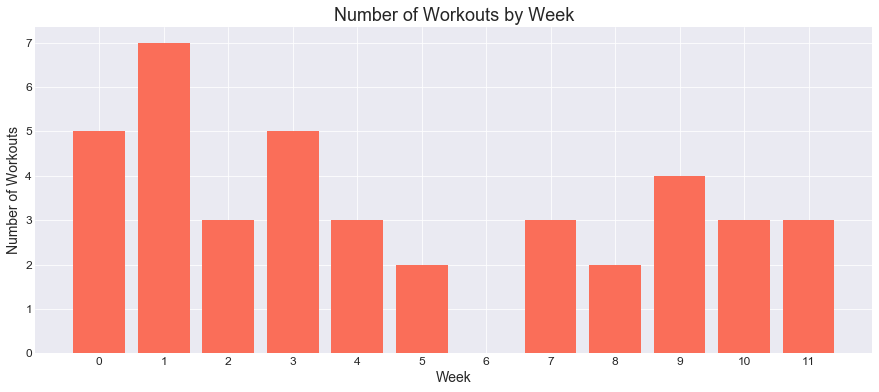

In [43]:
fig, ax = create_plot(title="Number of Workouts by Week", xlabel="Week",
                      ylabel="Number of Workouts")

ax.bar(x=workouts_by_week.index, height=workouts_by_week, color=tropical_colors_2[1]);
ax.set_xticks(range(12))

plt.show()

- Looks like I managed to get the most number of runs and swims in in the beginning of the quarter, before things got busy.
- Theres a dip in the midle of the quarter - around the time I started having midterms. And then there are no workouts in Week 6 (oops) when I had back-to-back tournaments.

In [44]:
workouts_by_weekday = group_by_weekday(workouts_f17, function="size").reindex(calendar.day_name)

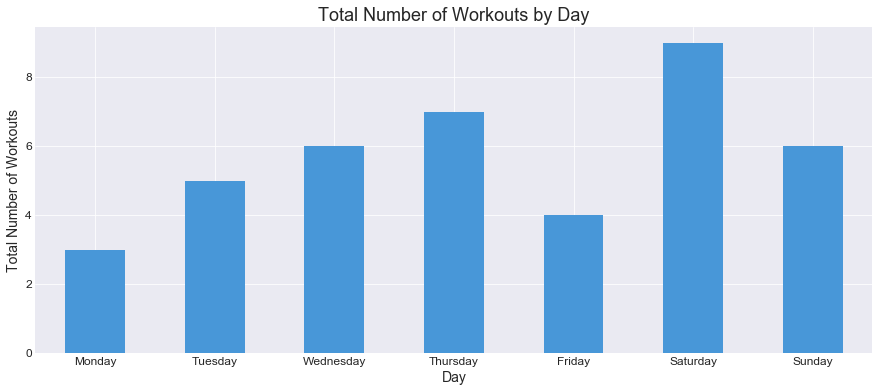

In [45]:
fig, ax = create_plot(title="Total Number of Workouts by Day", xlabel="Day",
                      ylabel="Total Number of Workouts")

workouts_by_weekday.plot(kind='bar', color=tropical_colors_2[0], rot=0)

plt.show()

Let's check out how the frequency of my runs and swims changed over the quarter.

### The Road to Recovery

I injured myself running in spring 2017, so for the second half of 2017 I swam a lot for my workouts. Towards the end of summer 2017, I was finally able to start slowly incorporating runs back into my routine. I bet we can see some of these trends in the data.

In [46]:
swims_by_week = group_by_week(workouts_f17['Swim'], fall_2017_start, "sum")
runs_by_week = group_by_week(workouts_f17['Run'], fall_2017_start, "sum")

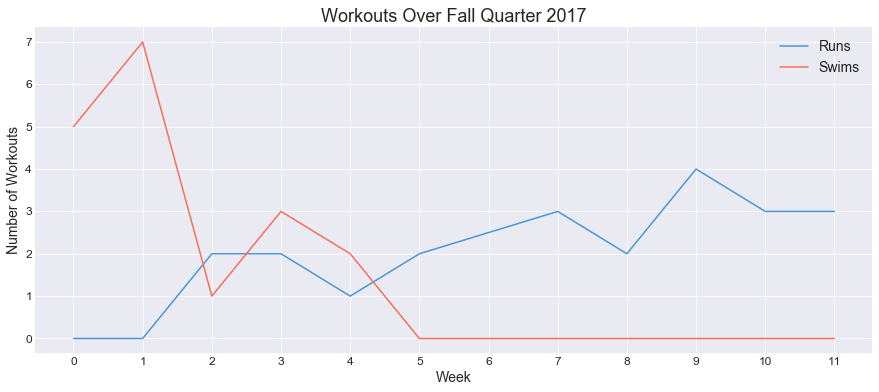

In [47]:
fig, ax = create_plot(title="Workouts Over Fall Quarter 2017", xlabel="Week",
                      ylabel="Number of Workouts")

for i, ts in enumerate([runs_by_week, swims_by_week]):
    ax.plot(ts, color=tropical_colors_2[i]);

ax.legend(['Runs', 'Swims'])
ax.set_xticks(range(12))

plt.show()

Trends:
- I started off the quarter mostly swimming for my workouts.
- The frequency of my swims decreased as the frequency of my runs increased. There's a few weeks where I was switching off between the two to give my knees a break between runs and to make sure I didn't injure myself running again.
- After week 5, I only ran for my workouts. At this point, I felt strong enough to just run with rest days. It was also getting cold enough in the evenings that the appeal of going for a run was far greater than the not-so-great appeal of going for a swim.

In [48]:
miles_by_week = group_by_week(workouts_f17['Run_length'], fall_2017_start, "sum")

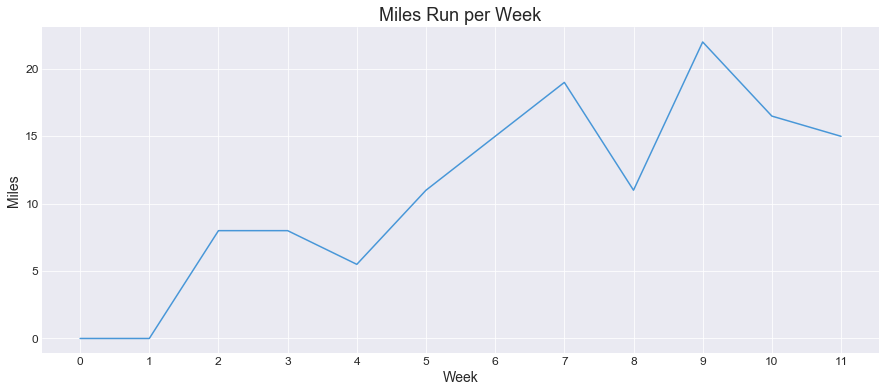

In [49]:
fig, ax = create_plot(title="Miles Run per Week", xlabel="Week", ylabel="Miles")

ax.plot(miles_by_week, color=tropical_colors_2[0]);
ax.set_xticks(range(12))

plt.show()

Yup, as the quarter progressed  - and as I started running more frequently and going for longer runs, my per-week mileage increased as well.

*(I love running a loooooot more than I love swimming.)*

# Social

This is the stuff on my calendar that includes: brunch & dinner with friends, mini golfing & hanging out, and lots and lots of mock trial practices.

In [50]:
social = pd.read_csv(data_path + "social.csv", skiprows=1,
                     names=["Event", "Start_time", "End_time"])

social = convert_columns(social)
social_f17 = filter_by_date(social, fall_2017_start, fall_2017_end)

social_f17.is_copy = False # avoid SettingWithCopyWarning
social_f17['total_time'] = social_f17.apply(lambda x: total_time(x), axis=1)

social_f17 = social_f17.set_index(['Start_time']) # change index to date
social_f17.index = social_f17.index.date
social_f17 = social_f17.drop(columns=['End_time'])

Gonna create a column to indicate whether an event is mock-trial related. (Because y'know, that's basically my social life.)

In [51]:
def is_mock_related(event):
    """
    Return True if an event is mock trial related, False otherwise.
    Params:
        event: string holding event description
    """
    regex_str = r".*(Mock|MT|Invitational|Tournament|Direct|Equal).*"
    mo = re.search(regex_str, event, re.IGNORECASE)
    if mo:
        return True
    return False

In [52]:
social_f17['is_mock'] = social_f17.apply(lambda x: is_mock_related(x['Event']), axis=1)
social_f17.head()

,Event,total_time,is_mock
2017-09-30,MT Team Dinner,2.5,True
2017-10-01,Brunch w/ Jenn & Stevie,1.0,False
2017-10-03,Mock Trial Practice,2.0,True
2017-10-03,Mock Trial Practice,1.5,True
2017-10-04,Mock Trial Practice,1.5,True


Hooray! Let's check out overall trends first.

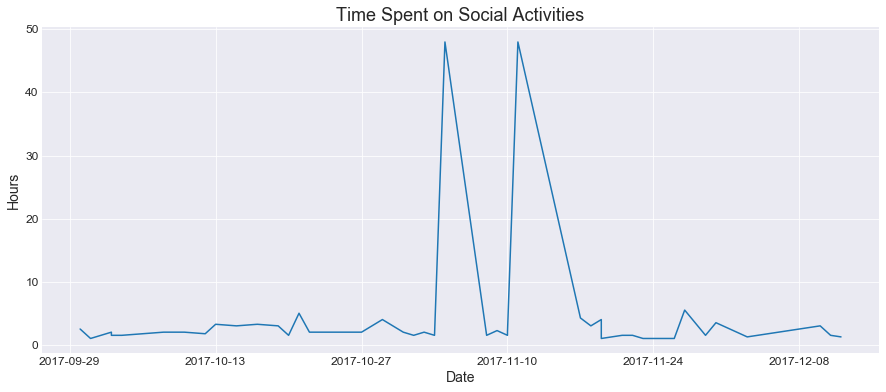

In [53]:
fig, ax = create_plot(title="Time Spent on Social Activities",
                      xlabel="Date", ylabel="Hours")

ax.plot(social_f17['total_time'])

plt.show()

Woah! Gonna check out those two spikes.

In [54]:
social_f17[social_f17['Event'].str.contains("Tournament")]

,Event,total_time,is_mock
2017-11-04,Vanderbilt Tournament,48.0,True
2017-11-11,Gunslinger Tournament,48.0,True


There are two events that last for 48 hours each - the two tournaments I went to this fall. They're so much longer than every other event that when they're included in the data, the details in the other events get lost - I'm gonna exclude them for some of my analysis.

In [55]:
social_f17_norm = social_f17[~social_f17['Event'].str.contains("Tournament")]

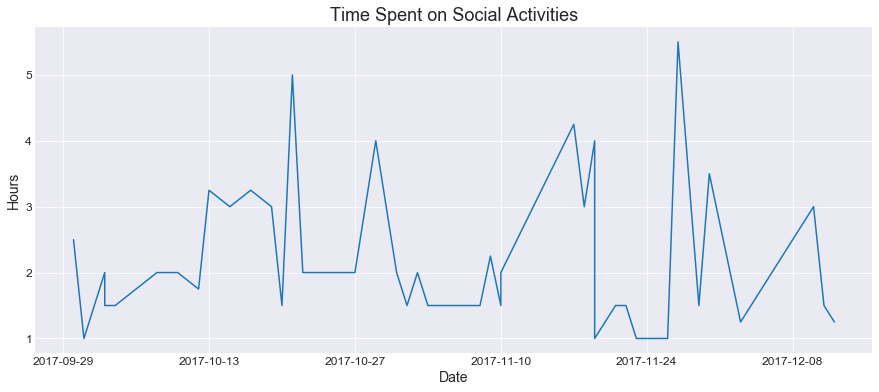

In [56]:
fig, ax = create_plot(title="Time Spent on Social Activities",
                      xlabel="Date", ylabel="Hours")

ax.plot(social_f17_norm['total_time'])

plt.show()

Much better - there's a lot more detail. Gonna try binning the data by week now.

In [57]:
social_by_week = group_by_week(social_f17_norm, fall_2017_start, 'sum')

### How much time do I spend on mock trial?

In [58]:
mock_data = social_f17_norm[social_f17_norm['is_mock']]
mock_by_week = group_by_week(mock_data, fall_2017_start, "sum")

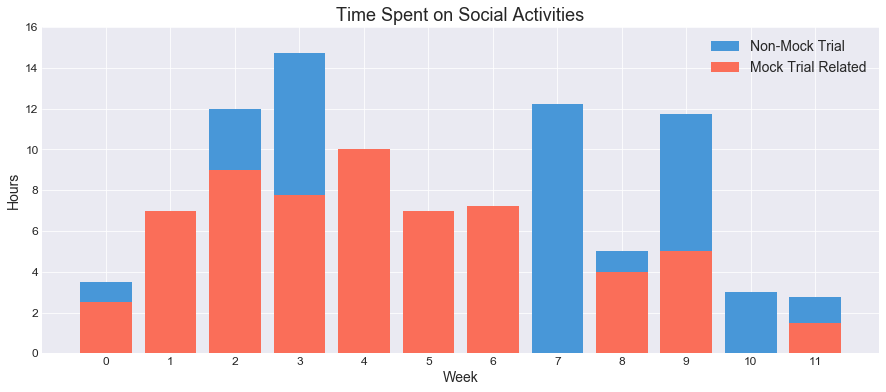

In [59]:
fig, ax = create_plot(title="Time Spent on Social Activities",
                      xlabel="Week", ylabel="Hours")

ax.bar(social_by_week.index, social_by_week['total_time'], color=tropical_colors_2[0])
ax.bar(mock_by_week.index, mock_by_week['total_time'], color=tropical_colors_2[1])

ax.legend(["Non-Mock Trial", "Mock Trial Related"])
ax.set_xticks(range(12))
ax.set_ylim(0,16)

plt.show()

Note:
- This doesn't include the two entire weekends I spent at the end of week 5 and week 6 at out-of-state mock trial tournaments.
- There are some events left off of my calendar (impromptu dinners, hangouts, etc.), so the amount of time spent on social activities is slightly underrepresented here.

**tl;dr mock trial has taken over my life**

# Work

In [60]:
work = pd.read_csv(data_path + "work.csv", skiprows=1,
                     names=["Event", "Start_time", "End_time"])

work = convert_columns(work)
work_f17 = filter_by_date(work, fall_2017_start, fall_2017_end)

work_f17.is_copy = False # avoid SettingWithCopyWarning
work_f17['total_time'] = work_f17.apply(lambda x: total_time(x), axis=1)

work_f17 = work_f17.set_index(['Start_time']) # change index to date
work_f17.index = work_f17.index.date
work_f17 = work_f17.drop(columns=['End_time'])

In [61]:
work_by_week = group_by_week(work_f17, fall_2017_start, "sum")

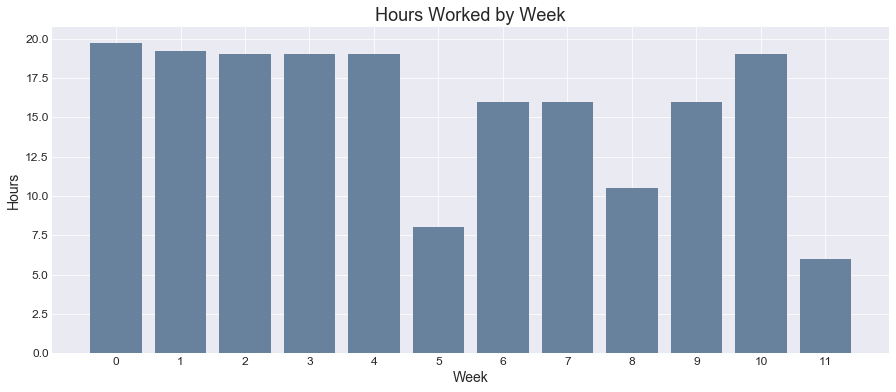

In [62]:
fig, ax = create_plot(title="Hours Worked by Week", ylabel="Hours", xlabel="Week")

ax.bar(work_by_week.index, work_by_week['total_time'], color="#68829E")
ax.set_xticks(work_by_week.index)

plt.show()

# Bringin' it all together

Gonna play around with some ways to visualize how I spent my time!

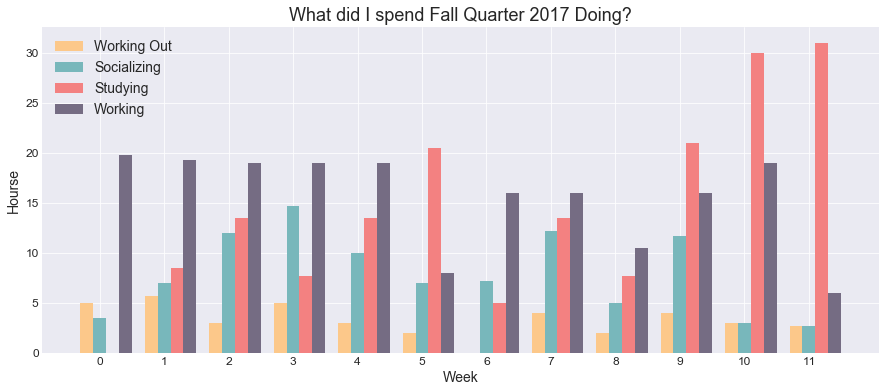

In [63]:
fig, ax = create_plot(title="What did I spend Fall Quarter 2017 Doing?", 
                      xlabel="Week", ylabel="Hourse")

categories = [workout_time_by_week, social_by_week, all_studying_by_week, work_by_week]
bar_colors = np.array(["#FCC88A", "#78B7BB", "#F38181", "#756C83"])

for i, category in enumerate(categories):
    ax.bar(x=category.index-0.2 + i*0.2, height=category['total_time'], width=0.2, 
           color=bar_colors[i])

ax.legend(['Working Out', 'Socializing', 'Studying', 'Working'])
ax.set_xticks(range(12))

plt.show()

In [64]:
# same data cleanup for the polar chart

# making time for week 0 small to avoid radius < 0 warning
week_0 = pd.DataFrame([[0, 0.01, 0, 0, 0]],
    columns=['Week', 'total_time', 'Studying_Math', 'Studying_Stats', 'Studying_Film']).set_index('Week')
all_studying_by_week = all_studying_by_week.append(week_0).sort_index()

week_6 = pd.DataFrame([[6, 0, 0, 0, 0.01]],
                      columns=['Week', 'Run', 'Run_length', 'Swim', 'total_time']).set_index('Week')
workout_time_by_week = workout_time_by_week.append(week_6).sort_index()

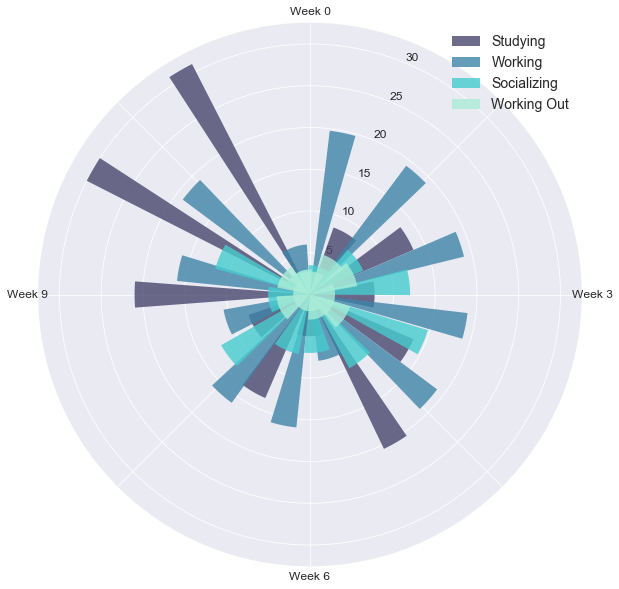

In [94]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')

N = 12 # 12 slices
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

study_radii = all_studying_by_week['total_time']
study_width =  np.pi / study_radii
work_radii = work_by_week['total_time']
work_width = np.pi / work_radii
workout_radii = workout_time_by_week['total_time']
workout_width = np.pi / workout_radii
social_radii = social_by_week['total_time']
social_width = np.pi / social_radii

radii = [study_radii, work_radii, social_radii, workout_radii]
width = [study_width, work_width, social_width, workout_width]

# colors = ["#7B77FF", "#92CCE1", "#F68686", "#FFE3B9"]
colors = ["#48466D", "#3D84A8", "#46CDCF", "#ABEDD8"]

for i, (radii, width) in enumerate(zip(radii, width)):
    ax.bar(theta + 0.2*i, radii, width=width, bottom=0.0, alpha=0.8, color=colors[i])
    
ax.legend(['Studying', 'Working', 'Socializing', 'Working Out'], loc='upper right')
ax.set_theta_direction(-1) # clockwise
ax.set_theta_offset(np.pi/2.0) # 0 degrees at "North" position
ax.set_xticklabels(['Week 0', '', 'Week 3', '', 'Week 6', '', 'Week 9', ''])

plt.show()

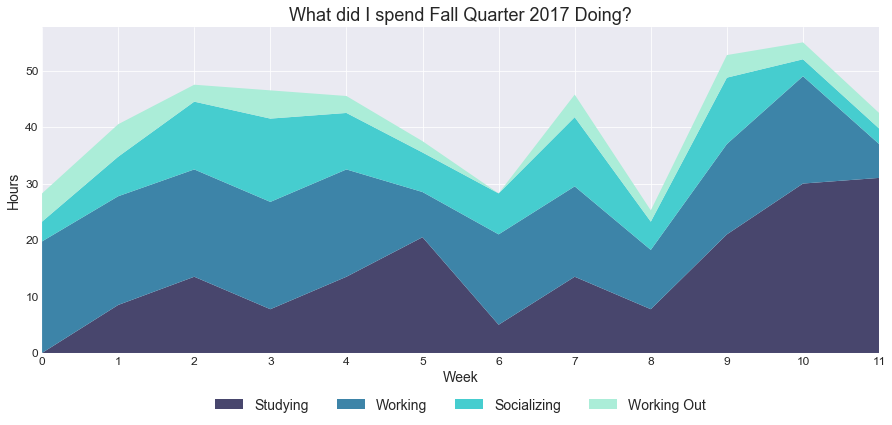

In [96]:
fig, ax = create_plot(title="What did I spend Fall Quarter 2017 Doing?",
                      xlabel="Week", ylabel="Hours")

x = range(12)
y = np.vstack([study_radii, work_radii, social_radii, workout_radii])

ax.stackplot(x, study_radii, work_radii, social_radii, workout_radii, colors=colors)
ax.legend(['Studying', 'Working', 'Socializing', 'Working Out'], ncol=4,
          loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlim(0, 11)
ax.set_xticks(x)

plt.show()